predicting the return of a stock in the US market using historical data over a recent period of 20 days

The one-day return of a stock :

$R^t$ =$ {P^t} \over {P^t}$$-1$

the goal is to find a model which beat the benchmark model's accuracy_score = 0.5131

Baseline Model's were only run on the train_set 

The  Model Report score (Accuracy) with preformed model (on the test_set for tunned models): 
    Decison tree baseline model : 0.510 (only done on the train_set)
    Decison tree tunned model : 0.5325 (Cross validation mean accuracy 0.52)
    Xgboost baseline model : 0.53  (Cross validation mean accuracy 0.53 ) (only done on the train_set)
    Xgboost tunned model : 0.8775  (Cross validation mean accuracy 0.54) 

Data description

3 datasets are provided as csv files, split between training inputs and outputs, and test inputs.

Input datasets comprise 47 columns: the first ID column contains unique row identifiers while the other 46 descriptive features correspond to:

* **DATE**: an index of the date (the dates are randomized and anonymized so there is no continuity or link between any dates),
* **STOCK**: an index of the stock,
* **INDUSTRY**: an index of the stock industry domain (e.g., aeronautic, IT, oil company),
* **INDUSTRY_GROUP**: an index of the group industry,
* **SUB_INDUSTRY**: a lower level index of the industry,
* **SECTOR**: an index of the work sector,
* **RET_1 to RET_20**: the historical residual returns among the last 20 days (i.e., RET_1 is the return of the previous day and so on),
* **VOLUME_1 to VOLUME_20**: the historical relative volume traded among the last 20 days (i.e., VOLUME_1 is the relative volume of the previous day and so on),

Output datasets are only composed of 2 columns:

* **ID**: the unique row identifier (corresponding to the input identifiers)
and the binary target:
* **RET**: the sign of the residual stock return at time $t$

The solution files submitted by participants shall follow this output dataset format (i.e contain only two columns, ID and RET, where the ID values correspond to the input test data). 
An example submission file containing random predictions is provided.

**418595 observations (i.e. lines) are available for the training datasets while 198429 observations are used for the test datasets.**


### Importing libraries

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve,classification_report,auc
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import tree
import seaborn as sns
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier

### Importing data

In [14]:
x_train = pd.read_csv("./x_train.csv")
y_train = pd.read_csv("./y_train.csv")
train_df = pd.concat([x_train, y_train], axis=1)
test_df = pd.read_csv("./x_test.csv")

In [15]:
target = 'RET'
IDcol = ['ID','STOCK', 'DATE','INDUSTRY','INDUSTRY_GROUP','SECTOR','SUB_INDUSTRY']

In [16]:
train_df = train_df.dropna()
train_df = train_df.drop(IDcol, axis = 1) 

In [18]:
test_df = test_df.dropna()
test_df = test_df.drop(IDcol, axis = 1) 

In [19]:
train_df.head(2)

,RET_1,VOLUME_1,RET_2,VOLUME_2,RET_3,VOLUME_3,RET_4,VOLUME_4,RET_5,VOLUME_5,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
0,-0.015748,0.147931,-0.015504,0.179183,0.010972,0.033832,-0.014672,-0.362868,0.016483,-0.972920,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
2,0.000440,-0.096282,-0.058896,0.084771,-0.009042,-0.298777,0.024852,-0.157421,0.009354,0.091455,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False


**Creat new parameters to increase the accurancy:**
- mean return of last 20 days
- the moving average of last 5 days
- the moving average of last 10 days
- the moving average of last 15 days

In [24]:
train_df['Mean'] = train_df[[f'RET_{i}' for i in range(1, 21)]].mean(axis=1)
test_df['Mean'] = test_df[[f'RET_{i}' for i in range(1, 21)]].mean(axis=1)
train_df['MA5'] = train_df[[f'RET_{i}' for i in range(1, 7)]].mean(axis=1)
train_df['MA10'] = train_df[[f'RET_{i}' for i in range(1, 11)]].mean(axis=1)
train_df['MA15'] = train_df[[f'RET_{i}' for i in range(1, 16)]].mean(axis=1)
test_df['MA5'] = test_df[[f'RET_{i}' for i in range(1, 7)]].mean(axis=1)
test_df['MA10'] = test_df[[f'RET_{i}' for i in range(1, 11)]].mean(axis=1)
test_df['MA15'] = test_df[[f'RET_{i}' for i in range(1, 16)]].mean(axis=1)


In [1]:
signe_of_return = LabelEncoder()
train_df['RET'] = signe_of_return.fit_transform(train_df['RET'])
test_df['RET'] = signe_of_return.fit_transform(test_df['RET'])

NameError: name 'LabelEncoder' is not defined

In [160]:
#Features Default selection
features = [x for x in train_df.columns if x not in [target]]


# Functions

In [ ]:
#Fonction d'evaluation 
def evaluation(model,X,Y,kfold):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(model, X, Y, cv=kfold, scoring='accuracy')
    scores2 = cross_val_score(model, X, Y, cv=kfold, scoring='precision')
    scores3 = cross_val_score(model, X, Y, cv=kfold, scoring='recall')
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.5f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.5f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation Recall: %0.5f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    return  

In [ ]:
def compute_roc(Y, y_pred, plot=True):
    fpr = dict()
    tpr = dict()
    auc_score = dict()
    fpr, tpr, _ = roc_curve(Y, y_pred)
    auc_score = auc(fpr, tpr)
    if plot:
        plt.figure(figsize=(7, 6))
        plt.plot(fpr, tpr, color='blue',
                 label='ROC curve (area = %0.2f)' % auc_score)
        plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
        plt.legend(loc="upper right")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title("ROC Curve")
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.show()
    return fpr, tpr, auc_score

In [ ]:
def feature_importance(model,features,selection=False) : 
    feature_importances = pd.DataFrame(model.feature_importances_  )
    feature_importances = feature_importances.T
    feature_importances.columns = [features]
    
    sns.set(rc={'figure.figsize':(13,12)})
    fig = sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)
    fig.set(title = 'Feature importance', xlabel = 'features', ylabel = 'features_importance' )
    
    if selection: #Selection of features with min 2% of feature importance
        n_features = feature_importances[feature_importances.loc[:,] > 0.02].dropna(axis='columns')
        n_features = n_features.columns.get_level_values(0)    
        print("Selected features")
        print(n_features)
        
    return fig

In [116]:
def modelfit(model,X,Y,features, performCV=True,roc=False, printFeatureImportance=False):
    
    #Fitting the model on the data_set
    model.fit(X[features],Y)
        
    #Predict training set:
    predictions = model.predict(X[features])
    predprob = model.predict_proba(X[features])[:,1]
    
    # Create and print confusion matrix    
    cfm = confusion_matrix(Y,predictions)
    print("\nModel Confusion matrix")
    print(cfm)
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(Y.values, predictions))
    
    #Perform cross-validation: evaluate using 10-fold cross validation 
    #kfold = StratifiedKFold(n_splits=10, shuffle=True)
    kfold = 2
    if performCV:
        evaluation(model,X[features],Y,kfold)
    if roc: 
        compute_roc(Y, predictions, plot=True)
          
    #Print Feature Importance:
    if printFeatureImportance:
        feature_importance(model,features,selection=False) 
        

## ML DecisionTreeClassifier

In [55]:
#Train and test set splitting
x_train, x_test, y_train, y_test = train_test_split(train.loc[:, train.columns != 'RET'], train.RET, test_size=0.25, random_state =0)

In [56]:
#Decison tree baseline model
model = tree.DecisionTreeClassifier()

In [71]:
#Fitting Decison tree baseline model
modelfit(model,x_train, y_train, features,performCV=False)
print("Accuracy on test set :{:.3f} ".format(model.score(x_test, y_test)))

[[117988      0]
 [     0 117632]]

Model Report
Accuracy : 1
Accuracy on test set :0.510 


In [11]:
#Tunning Decision tree model  With Gridsearch
print('Decision tree with Classifier')
params={'max_depth': np.arange(2, 7),'criterion':['gini','entropy']}
tree_estimator = tree.DecisionTreeClassifier()

grid_tree = GridSearchCV(tree_estimator, params, cv=kfold, scoring="accuracy",
                         n_jobs=1,
                         verbose=False)

grid_tree.fit(x_train, y_train)
best_est = grid_tree.best_estimator_
print(best_est)
print(grid_tree.best_score_)


# summarize results
print("Best: %f using %s" % (grid_tree.best_score_, grid_tree.best_params_))
means = grid_tree.cv_results_['mean_test_score']
stds = grid_tree.cv_results_['std_test_score']
params = grid_tree.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Decision tree with Classifier
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
0.5189160512689924
Best: 0.518916 using {'criterion': 'gini', 'max_depth': 6}
0.511026 (0.003405) with: {'criterion': 'gini', 'max_depth': 2}
0.514358 (0.003011) with: {'criterion': 'gini', 'max_depth': 3}
0.514010 (0.003979) with: {'criterion': 'gini', 'max_depth': 4}
0.516272 (0.004095) with: {'criterion': 'gini', 'max_depth': 5}
0.518916 (0.003918) with: {'criterion': 'gini', 'max_depth': 6}
0.510975 (0.003351) with: {'criterion': 'entropy', 'max_depth': 2}
0.514375 (0.003012) with: {'criterion': 'entropy', 'max_depth': 3}
0.513997 (0.003981) with: {'criterio

**the best Hyperparameters for our Decision tree model using gridsearch Cv  is {'criterion': 'gini', 'max_depth': 6}**


Model Confusion matrix
[[49456 68532]
 [43209 74423]]
Cross Validation Accuracy: 0.52 (+/- 0.00)
Cross Validation Precision: 0.51 (+/- 0.00)
Cross Validation Recall: 0.59 (+/- 0.02)

Model Report
Accuracy : 0.5258


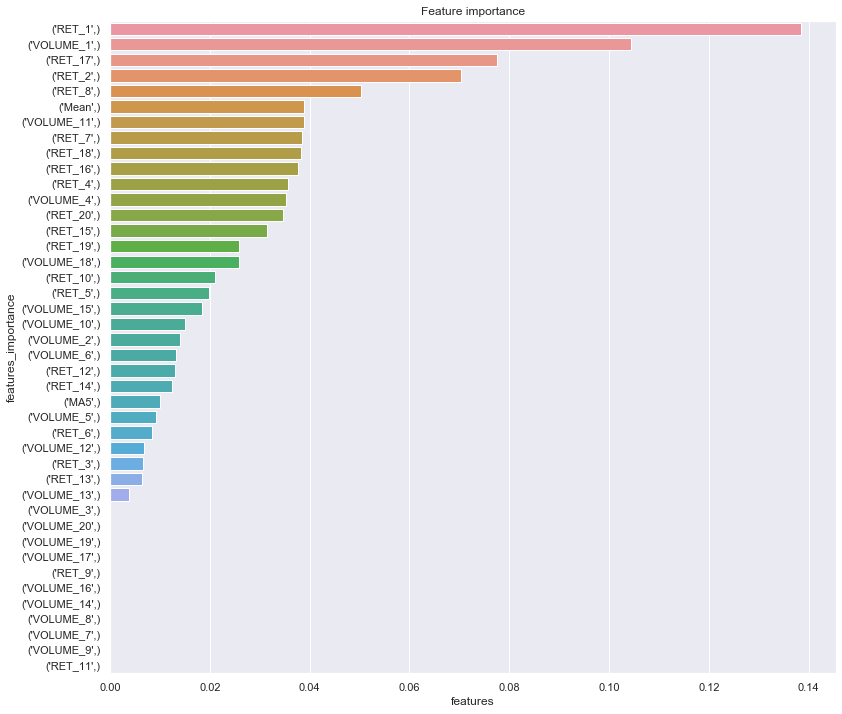

In [105]:
model = tree.DecisionTreeClassifier(max_depth = 6,criterion='gini')
modelfit(model,x_train, y_train,features,printFeatureImportance=True)

## features selection based on Feature importances 

Selected features
Index(['RET_1', 'VOLUME_1', 'RET_2', 'RET_4', 'VOLUME_4', 'RET_7', 'RET_8',
       'RET_10', 'VOLUME_11', 'RET_15', 'RET_16', 'RET_17', 'RET_18',
       'VOLUME_18', 'RET_19', 'RET_20', 'Mean'],
      dtype='object')


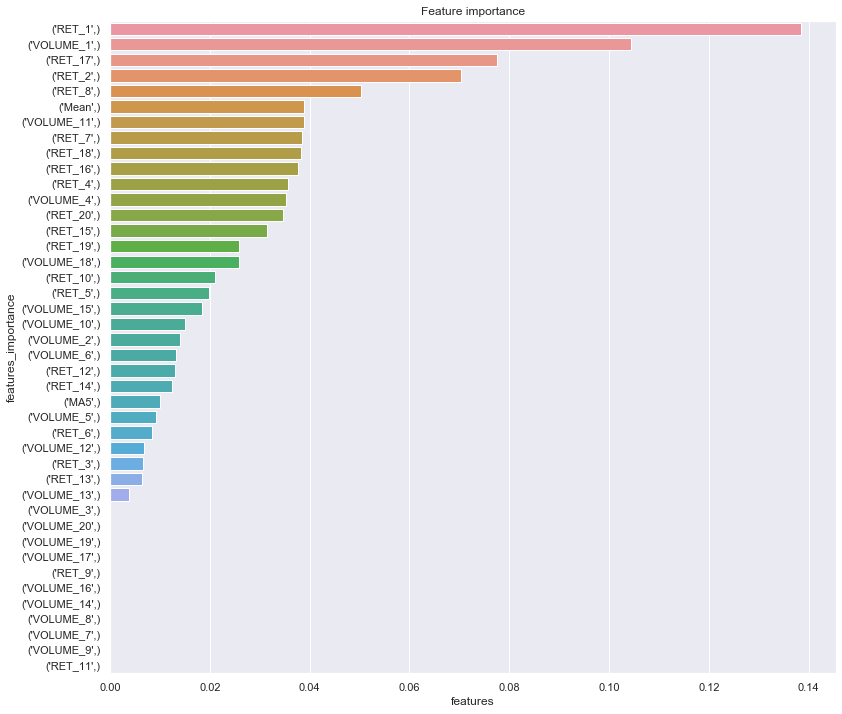

In [108]:
feature_importance(model,selection=True)

**we removed features with less than 2% of feature importance**

In [110]:
n_features = ['Mean', 'RET_1', 'RET_10','RET_15','RET_16', 'RET_17','RET_18', 'RET_19', 'RET_2', 
              'RET_20', 'RET_4', 'RET_7', 'RET_8','VOLUME_1', 'VOLUME_11', 'VOLUME_18', 'VOLUME_4']
#New sets 
x_train_sl, x_test_sl, y_train_sl, y_test_sl = train_test_split(train.loc[:, train[n_features].columns], train.RET, random_state =0)

In [111]:
model = tree.DecisionTreeClassifier(max_depth = 6,criterion='gini')

Fitting with train set

Model Confusion matrix
[[49697 68291]
 [43512 74120]]
Cross Validation Accuracy: 0.52 (+/- 0.00)
Cross Validation Precision: 0.51 (+/- 0.00)
Cross Validation Recall: 0.69 (+/- 0.03)

Model Report
Accuracy : 0.5255


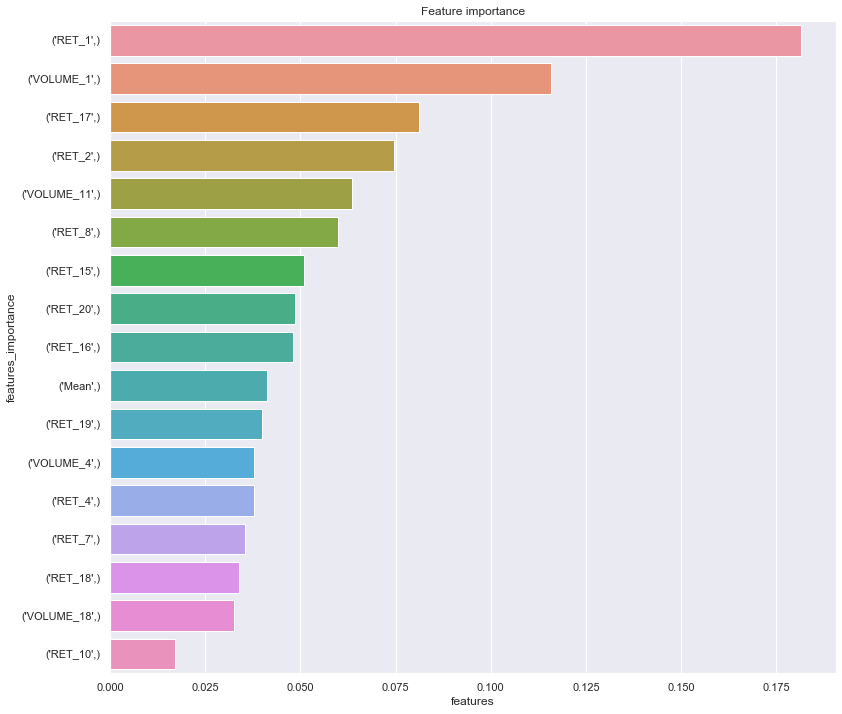

In [118]:
print("Fitting with train set")
modelfit(model,x_train_sl, y_train_sl,n_features,printFeatureImportance=True)

Fitting with test set

Model Confusion matrix
[[13150 26069]
 [10651 28670]]
Cross Validation Accuracy: 0.52 (+/- 0.00)
Cross Validation Precision: 0.52 (+/- 0.00)
Cross Validation Recall: 0.63 (+/- 0.03)


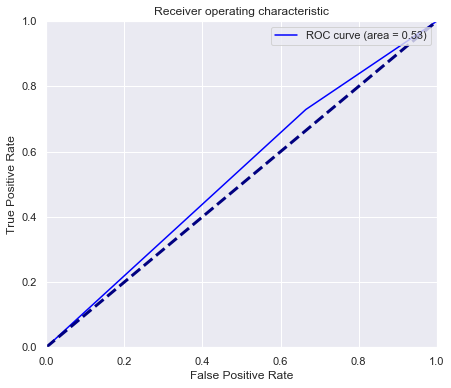


Model Report
Accuracy : 0.5325


In [119]:
print("Fitting with test set")
modelfit(model,x_test_sl, y_test_sl,n_features,printFeatureImportance=False,roc= True)

In [120]:
#Prediction on the test dataframe
testdf = testdf[n_features]
prediction = model.predict(testdf)
print(prediction)

[1 0 1 ... 1 0 1]


## ML GradientBoostingClassifier

In [161]:
#Train and test set splitting
x_train, x_test, y_train, y_test = train_test_split(train.loc[:, train.columns != 'RET'], train.RET, test_size=0.25, random_state=0)


Model Confusion matrix
[[60321 57667]
 [49448 68184]]
Cross Validation Accuracy: 0.53 (+/- 0.00)
Cross Validation Precision: 0.53 (+/- 0.00)
Cross Validation Recall: 0.56 (+/- 0.00)


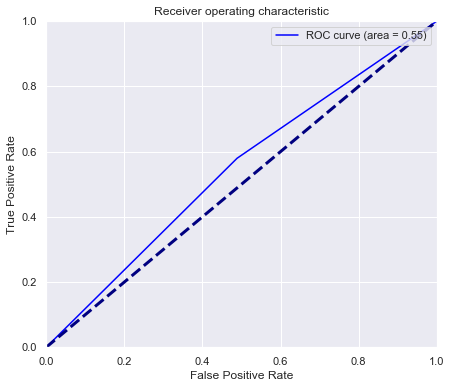


Model Report
Accuracy : 0.5454


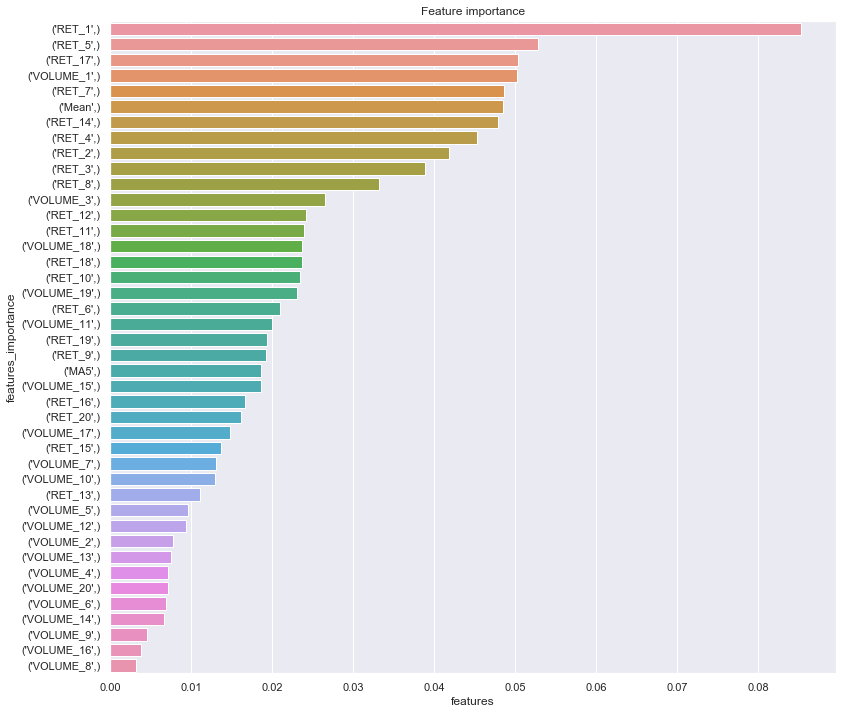

In [126]:
#Baseline Gradient boosting model 
base_gbm = GradientBoostingClassifier(random_state=10)
modelfit(base_gbm,x_train, y_train,features,roc=True,printFeatureImportance=True)

**Tunning parameters with Gridsearch**
** Baseline approch**
   *Fix learning rate and number of estimators for tuning tree-based parameters
    min_samples_split = 500 : This should be ~0.5-1% of total values.
    min_samples_leaf = 50 :  for preventing overfitting and again a small value.
    max_depth = 8 : Should be chosen (5-8) based on the number of observations and predictors.
    max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.
    subsample = 0.8 : commonly used used start value

**we will choose all the features 

In [ ]:
print('tuning n_estimators')
params1 = {'n_estimators':range(30,81,10)}

estimator = GradientBoostingClassifier(learning_rate=0.1, 
                                       min_samples_split=500,
                                       min_samples_leaf=50,
                                       max_depth=8,
                                       max_features='sqrt',
                                       subsample=0.8,
                                       random_state=10)

grid_xgb1 = GridSearchCV(estimator,
                  params1,
                  cv=5,
                  scoring='accuracy',
                  n_jobs=1,
                  verbose=False)
grid_result=grid_xgb1.fit(x_train, y_train)

In [86]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.536843 using {'n_estimators': 80}
0.532701 (0.001290) with: {'n_estimators': 30}
0.533660 (0.001946) with: {'n_estimators': 40}
0.534607 (0.001868) with: {'n_estimators': 50}
0.535625 (0.001503) with: {'n_estimators': 60}
0.536724 (0.001644) with: {'n_estimators': 70}
0.536843 (0.001746) with: {'n_estimators': 80}


In [ ]:
print('tuning max_depth and min_sample_split')
params2 =  {'max_depth':range(5,16,2), 'min_samples_split':range(400,1001,200)}

estimator = GradientBoostingClassifier(learning_rate=0.1,
                                       n_estimators = 80,
                                       max_features='sqrt',
                                       subsample=0.8,
                                       random_state=10)

grid_xgb2 = GridSearchCV(estimator,
                  params2,
                  cv=5,
                  scoring='accuracy',
                  n_jobs=-1,
                  verbose=True)

grid_result=grid_xgb2.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

tuning max_depth and min_sample_split
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 134.9min finished
Best: 0.540790 using {'max_depth': 15, 'min_samples_split': 400}
0.532043 (0.000315) with: {'max_depth': 5, 'min_samples_split': 400}
0.532069 (0.000926) with: {'max_depth': 5, 'min_samples_split': 600}
0.532281 (0.000915) with: {'max_depth': 5, 'min_samples_split': 800}
0.531996 (0.001207) with: {'max_depth': 5, 'min_samples_split': 1000}
0.535426 (0.001870) with: {'max_depth': 7, 'min_samples_split': 400}
0.534912 (0.000907) with: {'max_depth': 7, 'min_samples_split': 600}
0.535163 (0.001501) with: {'max_depth': 7, 'min_samples_split': 800}
0.534989 (0.001050) with: {'max_depth': 7, 'min_samples_split': 1000}
0.537268 (0.001484) with: {'max_depth': 9, 'min_samples_split': 400}
0.537225 (0.001056) with: {'max_depth': 9, 'min_samples_split': 600}
0.536886 (0.002497) with: {'max_depth': 9, 'min_samples_split': 800}
0.535931 (0.000559) with: {'max_depth': 9, 'min_samples_split': 1000}
0.538961 (0.001785) with: {'max_depth': 11, 'min_samples_split': 400}
0.538715 (0.001752) with: {'max_depth': 11, 'min_samples_split': 600}
0.539016 (0.002292) with: {'max_depth': 11, 'min_samples_split': 800}
0.537764 (0.002626) with: {'max_depth': 11, 'min_samples_split': 1000}
0.540009 (0.000849) with: {'max_depth': 13, 'min_samples_split': 400}
0.539254 (0.001786) with: {'max_depth': 13, 'min_samples_split': 600}
0.538851 (0.001672) with: {'max_depth': 13, 'min_samples_split': 800}
0.539967 (0.001591) with: {'max_depth': 13, 'min_samples_split': 1000}
0.540790 (0.002216) with: {'max_depth': 15, 'min_samples_split': 400}
0.539504 (0.001396) with: {'max_depth': 15, 'min_samples_split': 600}
0.540633 (0.002234) with: {'max_depth': 15, 'min_samples_split': 800}
0.539700 (0.002217) with: {'max_depth': 15, 'min_samples_split': 1000}

In [131]:
# the best parameter is give by Best: 0.540790 using {'max_depth': 15, 'min_samples_split': 400}
print('tuning num_sample_split and min_sample_split')
params3 =  {'min_samples_leaf':range(40,70,10), 'min_samples_split':range(400,1001,200)}
estimator = GradientBoostingClassifier(learning_rate=0.1,
                                       n_estimators = 80,
                                       max_depth=15,
                                       max_features='sqrt',
                                       subsample=0.8,
                                       random_state=10)
grid_xgb3 = GridSearchCV(estimator,
                  params3,
                  cv=5,
                  scoring='accuracy',
                  n_jobs=-1,
                  verbose=True)
grid_result=grid_xgb3.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

tuning num_sample_split and min_sample_split
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 58.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 89.3min finished


Best: 0.543362 using {'min_samples_leaf': 40, 'min_samples_split': 400}
0.543362 (0.001839) with: {'min_samples_leaf': 40, 'min_samples_split': 400}
0.539920 (0.002247) with: {'min_samples_leaf': 40, 'min_samples_split': 600}
0.539016 (0.002462) with: {'min_samples_leaf': 40, 'min_samples_split': 800}
0.541087 (0.001309) with: {'min_samples_leaf': 40, 'min_samples_split': 1000}
0.539644 (0.001842) with: {'min_samples_leaf': 50, 'min_samples_split': 400}
0.539886 (0.001325) with: {'min_samples_leaf': 50, 'min_samples_split': 600}
0.541889 (0.001254) with: {'min_samples_leaf': 50, 'min_samples_split': 800}
0.540625 (0.001787) with: {'min_samples_leaf': 50, 'min_samples_split': 1000}
0.540264 (0.003122) with: {'min_samples_leaf': 60, 'min_samples_split': 400}
0.540561 (0.002069) with: {'min_samples_leaf': 60, 'min_samples_split': 600}
0.540514 (0.001905) with: {'min_samples_leaf': 60, 'min_samples_split': 800}
0.539992 (0.002170) with: {'min_samples_leaf': 60, 'min_samples_split': 1000}


In [132]:
#Model fitting of the Grid search best estimator
modelfit(grid_xgb3.best_estimator_,x_train, y_train,features,roc=False)


Model Confusion matrix
[[83842 34146]
 [27365 90267]]
Cross Validation Accuracy: 0.54 (+/- 0.00)
Cross Validation Precision: 0.53 (+/- 0.00)
Cross Validation Recall: 0.56 (+/- 0.00)

Model Report
Accuracy : 0.7389


In [133]:
modelfit(grid_xgb3.best_estimator_,x_test, y_test,features,roc=False)


Model Confusion matrix
[[29744  9475]
 [ 7205 32116]]
Cross Validation Accuracy: 0.53 (+/- 0.00)
Cross Validation Precision: 0.53 (+/- 0.00)
Cross Validation Recall: 0.54 (+/- 0.00)

Model Report
Accuracy : 0.7876


In [134]:
grid_xgb3.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=15,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=40, min_samples_split=400,
                           min_weight_fraction_leaf=0.0, n_estimators=80,
                           n_iter_no_change=None, presort='auto',
                           random_state=10, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [146]:
print('tuning max_features')
params4 =  {'max_features':range(7,20,2)}

estimator = GradientBoostingClassifier(learning_rate=0.1,
                                       n_estimators = 80,
                                       max_depth=15,
                                        min_samples_split=400, 
                                       min_samples_leaf=40, 
                                       subsample=0.8,
                                       random_state=10)
grid_xgb4 = GridSearchCV(estimator,
                  params4,
                  cv=5,
                  scoring='accuracy',
                  n_jobs=1,
                  verbose=True)
grid_result=grid_xgb4.fit(x_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds , params):
    print("%f (%f) with: %r" % (mean, stdev, param))

tuning max_features
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed: 613.4min finished


Best: 0.542110 using {'max_features': 19}
0.539649 (0.000548) with: {'max_features': 7}
0.539585 (0.001651) with: {'max_features': 9}
0.540285 (0.001833) with: {'max_features': 11}
0.540230 (0.001879) with: {'max_features': 13}
0.538893 (0.001778) with: {'max_features': 15}
0.539937 (0.001116) with: {'max_features': 17}
0.542110 (0.001251) with: {'max_features': 19}


In [147]:
xgb_tunned = GradientBoostingClassifier(learning_rate=0.1,
                                       n_estimators = 80,
                                       max_depth=19,
                                        min_samples_split=400, 
                                       min_samples_leaf=40, 
                                       subsample=0.8,
                                       random_state=1 )


Model Confusion matrix
[[95004 22984]
 [18539 99093]]
Cross Validation Accuracy: 0.54 (+/- 0.00)
Cross Validation Precision: 0.54 (+/- 0.00)
Cross Validation Recall: 0.55 (+/- 0.00)

Model Report
Accuracy : 0.8238

Model Confusion matrix
[[33859  5360]
 [ 4263 35058]]
Cross Validation Accuracy: 0.53 (+/- 0.00)
Cross Validation Precision: 0.53 (+/- 0.00)
Cross Validation Recall: 0.54 (+/- 0.00)

Model Report
Accuracy : 0.8775


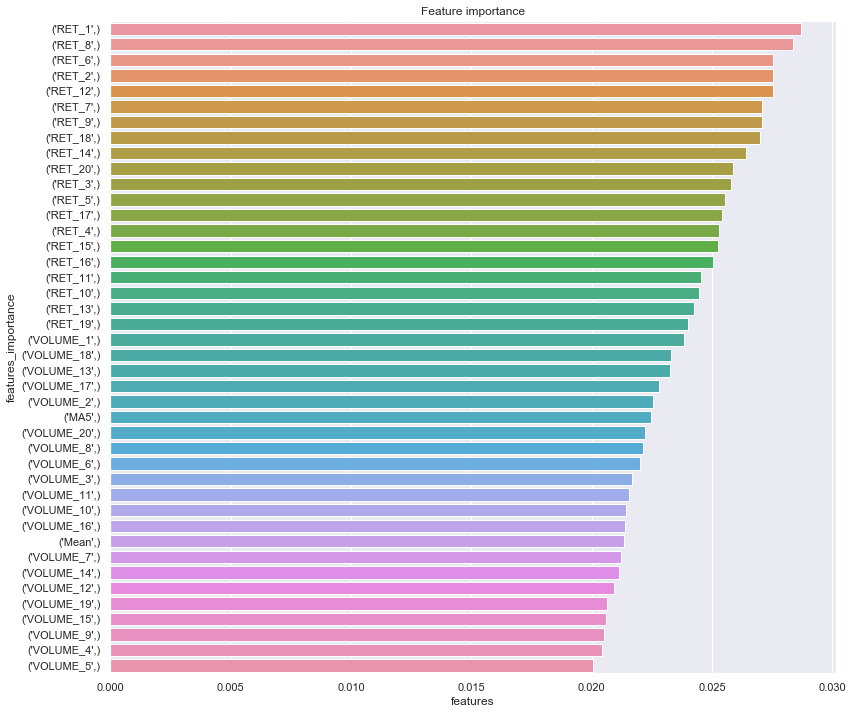

In [163]:
#Fit Cross validation and prediction on the train and the test set
modelfit(xgb_tunned,x _train, y_train,features,performCV=True,roc=False,printFeatureImportance=True)
modelfit(xgb_tunned,x_test, y_test,features,performCV=True,roc=False)